In [1]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO
import torchvision.transforms as transforms
import torchvision.ops as ops
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as patches
import matplotlib.image as mpimg
import json

In [2]:
def have_no_similar_elements(arr1, arr2):
    common_elements = set(arr1) & set(arr2)
    return len(common_elements) == 0

In [3]:
class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = self._get_valid_image_ids()
        
    def _get_valid_image_ids(self):
        # Get image IDs with valid annotations
        valid_ids = []
        for img_id in self.coco.imgs.keys():
            ann_ids = self.coco.getAnnIds(imgIds=img_id)
            if len(ann_ids) > 0:
                valid_ids.append(img_id)
        return valid_ids

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]['file_name']
        # open the input image
        img = Image.open(os.path.join(self.root, path)).convert("RGB")
        # list of classes which we want to recognize(these are bed, sofa, table and chair)
        # P.S. I initially created the dataset with 7 types of labels, but it seems that in order to
        # correctly recoginize all 7 types of furniture we need much more than 1000 frames,
        # what leads to much longer time of CNN training
        requiered_classes = [1, 5, 6, 7]
        
        if len(coco_annotation) == 0:
            # Skip images with no annotations
            return self.__getitem__((index + 1) % len(self.ids))

        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        with open('./solo/sequence.0/step{step_id}.frame_data.json'.format(step_id = img_id)) as f:
            solo_file = json.load(f)
            is_visible = []
            object_ids = []
            for i in range(num_objs):
                if solo_file['metrics'][0]['values'][i]['percentVisible'] < 0.8:
                    is_visible.append(False)
                else:
                    is_visible.append(True)
            
        if not any(is_visible):
            return self.__getitem__((index + 1) % len(self.ids))
        
        boxes = []
        for i in range(num_objs):
            if is_visible[i] and coco_annotation[i]['category_id'] in requiered_classes:
                xmin = coco_annotation[i]['bbox'][0]
                ymin = coco_annotation[i]['bbox'][1]
                xmax = xmin + coco_annotation[i]['bbox'][2]
                ymax = ymin + coco_annotation[i]['bbox'][3]
                boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        labels = []
        # Some objects are almost invisible in images, so we need to remove them from labels
        for i in range(num_objs):
            if is_visible[i] and coco_annotation[i]['category_id'] in requiered_classes:
                label = coco_annotation[i]['category_id']
                labels.append(label)
                
        if have_no_similar_elements(labels, requiered_classes):
            return self.__getitem__((index + 1) % len(self.ids))

        transform_dict = {1:1, 5:2, 6:3, 7:4}
        transformed_labels = [transform_dict.get(label, label) for label in labels]
        labels = transformed_labels
            
        labels = torch.tensor(labels, dtype=torch.int64)
        
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            if is_visible[i] and coco_annotation[i]['category_id'] in requiered_classes:
                areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)

In [4]:
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.112, 0.112, 0.113], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [5]:
def image_shower(images, labels, n=1):
    for i, image in enumerate(images[:n]):
        fig, ax = plt.subplots(1)
        plt.subplot(n, n, i + 1)
        #image = image/ 2 + 0.5
        ax.imshow(image.numpy().transpose((1, 2, 0)).squeeze())
        print(labels[0]['image_id'])
    for box in labels[0]["boxes"]:
        # Extract coordinates
        x_min, y_min, x_max, y_max = box
        print(box)
    
        # Calculate width and height
        width = x_max - x_min
        height = y_max - y_min
    
        # Create rectangle patch
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
        # Add rectangle patch to axes
        ax.add_patch(rect)
    ax.set_aspect('equal')
    plt.show()
    print("Real Labels: ", ' '.join('%5s' % classes[label.item()] for label in labels[0]["labels"]))

In [6]:
train_data_dir = './coco/images'
train_coco = './coco/bbox.json'

# create own Dataset
my_dataset = myOwnDataset(root=train_data_dir,
                          annotation=train_coco,
                          transforms=get_transform()
                          )

# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

# Batch size
train_batch_size = 10

# own DataLoader
data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=0,
                                          collate_fn=collate_fn)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


tensor([265])
tensor([ 77., 149., 270., 260.])


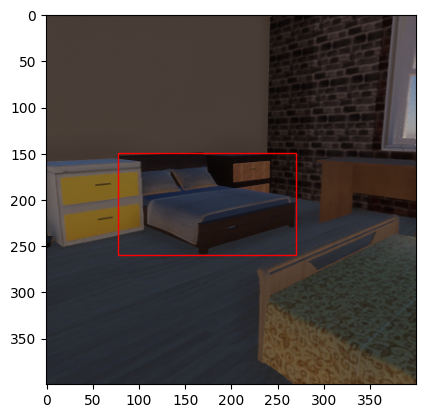

Real Labels:    bed


In [7]:
classes = {1:'bed', 2: 'Sofa', 3:"Table", 4:"Chair"}
images, labels = next(iter(data_loader))
image_shower(images, labels)

In [30]:
torch.cuda.empty_cache()

In [31]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model
    

# There are 4 types of furniture + background
num_classes = 5
num_epochs = 1
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    for imgs, annotations in data_loader:
        
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        
    
        loss_dict = model(imgs, annotations)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')

Iteration: 1/110, Loss: 1.9825518131256104
Iteration: 2/110, Loss: 0.7983506917953491
Iteration: 3/110, Loss: 0.4888399541378021
Iteration: 4/110, Loss: 0.5394546985626221
Iteration: 5/110, Loss: 0.5015347599983215
Iteration: 6/110, Loss: 0.5067448019981384
Iteration: 7/110, Loss: 0.5591224431991577
Iteration: 8/110, Loss: 0.4599428176879883
Iteration: 9/110, Loss: 0.4780946373939514
Iteration: 10/110, Loss: 0.35990971326828003
Iteration: 11/110, Loss: 0.2869414985179901
Iteration: 12/110, Loss: 0.24544818699359894
Iteration: 13/110, Loss: 0.34471791982650757
Iteration: 14/110, Loss: 0.29456591606140137
Iteration: 15/110, Loss: 0.28819355368614197
Iteration: 16/110, Loss: 0.403732568025589
Iteration: 17/110, Loss: 0.30069729685783386
Iteration: 18/110, Loss: 0.3680383861064911
Iteration: 19/110, Loss: 0.29160118103027344
Iteration: 20/110, Loss: 0.2863471806049347
Iteration: 21/110, Loss: 0.26464593410491943
Iteration: 22/110, Loss: 0.3368091881275177
Iteration: 23/110, Loss: 0.2915506

In [32]:
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [33]:
def get_transform_test():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.Resize((400, 400)))
    custom_transforms.append(torchvision.transforms.ToTensor())
    #custom_transforms.append(transforms.Normalize([0.162, 0.162, 0.163], [0.112, 0.112, 0.112]))
    return torchvision.transforms.Compose(custom_transforms)

In [46]:
random_image_path = "sofa1.jpg"
img = Image.open(random_image_path).convert("RGB")
transform = get_transform_test()
img = transform(img)
img = img.unsqueeze(0)  # Add a batch dimension

In [47]:
img = img.to(device)
with torch.no_grad():
    predictions = model(img)

In [48]:
boxes = predictions[0]["boxes"].cpu().numpy()
labels = predictions[0]["labels"].cpu().numpy()
scores = predictions[0]["scores"].cpu().numpy()

# Apply non-maximum suppression (NMS) to filter the bounding box predictions
keep = ops.nms(torch.from_numpy(boxes), torch.from_numpy(scores), iou_threshold = 0.5)

# Filter the bounding boxes, labels, and scores using the NMS results
boxes = boxes[keep]
labels = labels[keep]
scores = scores[keep]

[ 44.23703 195.81493 359.07446 361.55713]
[ 39.30725 177.52173 200.69847 344.27155]


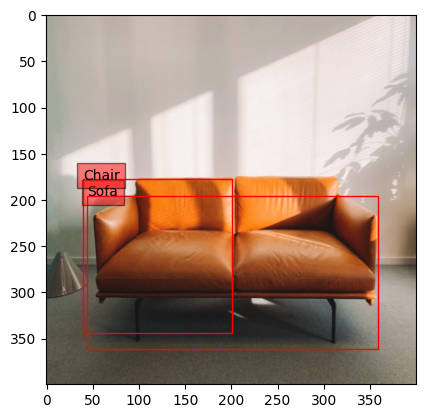

In [49]:

# Convert image tensor to numpy array
image = img.squeeze(0).permute(1, 2, 0).cpu().numpy()

# Create figure and axes
fig, ax = plt.subplots(1)
ax.imshow(image)


if isinstance(labels, np.int64):
    label = labels
    labels = []
    labels.append(label)
    box = boxes
    boxes = []
    boxes.append(box)

# Iterate over bounding boxes and labels
for box, label in zip(boxes, labels):
    # Extract coordinates
    x_min, y_min, x_max, y_max = box
    print(box)
    
    # Calculate width and height
    width = x_max - x_min
    height = y_max - y_min
    
    # Create rectangle patch
    rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
    
    # Add rectangle patch to axes
    ax.add_patch(rect)
    
    # Add label text to axes
    ax.text(x_min, y_min, f"{classes[label]}", bbox=dict(facecolor='r', alpha=0.5))

# Set aspect ratio and show plot
ax.set_aspect('equal')
plt.show()